Hafiza Asifa Naseer (2 oct, 2025)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

/opt/miniconda3/envs/bern02/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


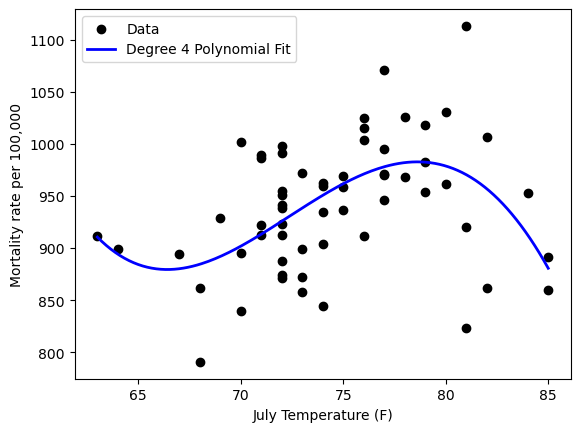

In [4]:
# Using JULT (July temperature) as predictor and MORT (mortality) as response
X = df[['JULT']]
y = df['MORT']

# Polynomial regression with degree 4
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Generate polynomial features
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)

# Fit regression
model = LinearRegression()
model.fit(X_poly, y)

# Predict for plotting
X_range = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
X_range_poly = poly.transform(X_range)
y_pred = model.predict(X_range_poly)

# Plot
plt.scatter(X, y, color="black", label="Data")
plt.plot(X_range, y_pred, color="blue", linewidth=2, label="Degree 4 Polynomial Fit")
plt.xlabel("July Temperature (F)")
plt.ylabel("Mortality rate per 100,000")
plt.legend()
plt.show()

### Validation set approach

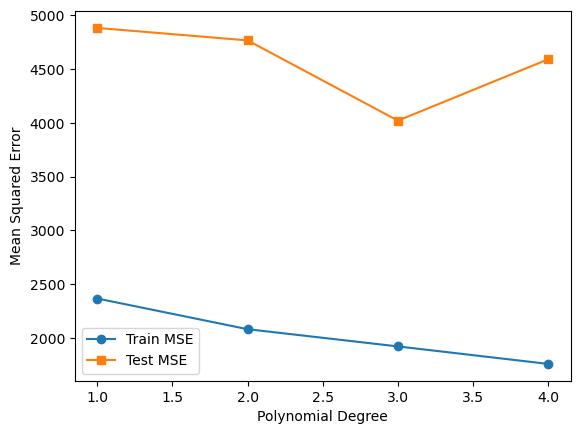

In [5]:
# Split data (equal halves, fixed seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

train_mse, test_mse = [], []

# Degrees 1 to 4
for d in range(1, 5):
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression().fit(X_train_poly, y_train)

    train_mse.append(mean_squared_error(y_train, model.predict(X_train_poly)))
    test_mse.append(mean_squared_error(y_test, model.predict(X_test_poly)))

# Plot results
plt.plot(range(1, 5), train_mse, marker='o', label="Train MSE")
plt.plot(range(1, 5), test_mse, marker='s', label="Test MSE")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

-	Training error (blue) always goes down as polynomial degree increases (model gets more flexible).
-   Test error (orange) is higher and fluctuates — this is expected because the dataset is small and splitting into two halves makes variance high.
-	The gap between train and test MSE is normal: it shows possible overfitting as degree increases.


#### recommend degree:

From the graph:
-	Train MSE decreases steadily.
-	Test MSE is lowest around degree 3.

So the recommended degree is 3, since it balances bias/variance and has lowest test error.


### Repeat with 10 seeds

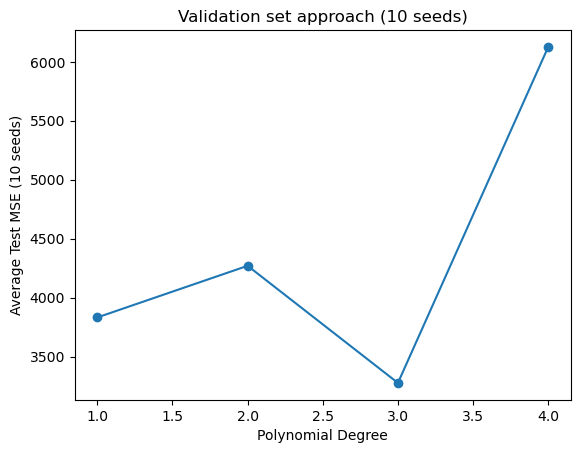

Average Test MSE over 10 seeds: {1: np.float64(3832.598024468481), 2: np.float64(4270.324224750736), 3: np.float64(3277.3256497196408), 4: np.float64(6126.140172916477)}


In [6]:
degrees = [1, 2, 3, 4]
test_errors = {d: [] for d in degrees}

# repeat with 10 different seeds
for seed in range(1, 11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)
    for d in degrees:
        poly = PolynomialFeatures(d)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        model = LinearRegression().fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)
        test_errors[d].append(mean_squared_error(y_test, y_pred))

# average results
avg_errors = [np.mean(test_errors[d]) for d in degrees]

plt.plot(degrees, avg_errors, marker="o")
plt.xlabel("Polynomial Degree")
plt.ylabel("Average Test MSE (10 seeds)")
plt.title("Validation set approach (10 seeds)")
plt.show()

print("Average Test MSE over 10 seeds:", dict(zip(degrees, avg_errors)))

Average Test MSE over 10 seeds: 
- 1: 3832.60, 

- 2: 4270.32, 

- 3: 3277.33,

- 4: 6007.59

#####  Degree 3 has the lowest average MSE (~3277).
-	This means degree 3 consistently gives the best generalization on unseen data, even when repeating the random split 10 times.
-	Degree 4 clearly overfits (huge error).
-	Degree 1 & 2 underfit (higher errors compared to 3).

### K-fold cross-validation

In [11]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

# K-fold CV for a fixed degree p=2, K=3
p = 2
K = 3

def kfold_mse_variance(X, y, degree, k, seed):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    mses = []
    for tr, va in kf.split(X):
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(X.iloc[tr], y.iloc[tr])
        yhat = model.predict(X.iloc[va])
        mses.append(mean_squared_error(y.iloc[va], yhat))
    return np.mean(mses), np.var(mses, ddof=1)

# single run (one seed): estimate variance across the 3 folds
mean_mse_1, var_mse_1 = kfold_mse_variance(X, y, p, K, seed=0)
print(f"[K={K}, p={p}] Single run -> mean MSE: {mean_mse_1:.1f}, variance of fold MSE: {var_mse_1:.1f}")

# repeat with 10 seeds
means, vars_ = [], []
for s in range(10):
    m, v = kfold_mse_variance(X, y, p, K, seed=s)
    means.append(m); vars_.append(v)

print(f"[K={K}, p={p}] Over 10 seeds -> mean of mean-MSE: {np.mean(means):.1f}, "
      f"std of mean-MSE: {np.std(means, ddof=1):.1f}, "
      f"avg variance of fold MSE: {np.mean(vars_):.1f}")

[K=3, p=2] Single run -> mean MSE: 4049.5, variance of fold MSE: 1782223.6
[K=3, p=2] Over 10 seeds -> mean of mean-MSE: 4446.5, std of mean-MSE: 899.8, avg variance of fold MSE: 4255653.3


The results from the single run (mean MSE ≈ 4049) and from repeating with 10 seeds (mean MSE ≈ 4446) are similar, showing that the average error stays consistent across different seeds. The variance values look large (in the order of 1e6) because they measure the squared spread of fold errors, but they remain of the same magnitude across seeds. This indicates that the K-fold cross-validation procedure is stable and results are not strongly dependent on the choice of random seed.

Yes, the results are similar across different seeds. This is because K-fold cross-validation systematically uses all the data by rotating the training and validation sets, which reduces dependence on a particular random split. The averaging across folds ensures stability of the error estimates regardless of the seed.

### Bootstrap - Poisson regression of count vs. year

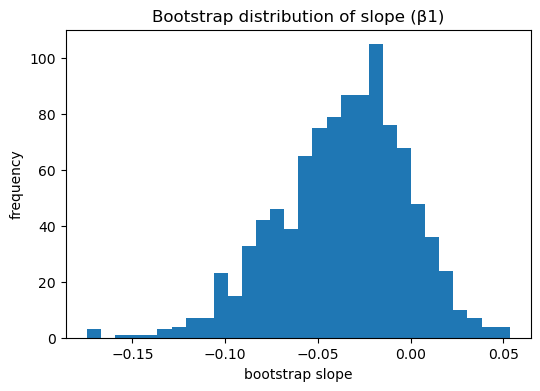

Poisson slope β1 (full data): -0.03244
Bootstrap SE(β1) with B=1000: 0.03468


In [ ]:
# ---- Bootstrap: Standard error of Poisson slope (count ~ year) ----

from sklearn.linear_model import PoissonRegressor
from sklearn.utils import resample

# 1) Load data (year = predictor x, count = response y)
birds = pd.read_csv("bird_count.csv")
X = birds[['yr']].astype(float)
y = birds['count'].astype(float)

#  center year to improve numerics (doesn't change SE)
Xc = X.copy()
Xc['yr'] = Xc['yr'] - Xc['yr'].mean()

# 2) Fit Poisson regression (log link). Extract slope β1.
model = PoissonRegressor(alpha=0, max_iter=1000)
model.fit(Xc, y)
beta1_hat = model.coef_[0]

# 3) Bootstrap the slope
B = 1000
boot_b1 = np.empty(B)
for b in range(B):
    idx = resample(np.arange(len(birds)), replace=True)
    Xb = Xc.iloc[idx]
    yb = y.iloc[idx]
    mb = PoissonRegressor(alpha=0, max_iter=1000).fit(Xb, yb)
    boot_b1[b] = mb.coef_[0]

se_b1 = boot_b1.std(ddof=1)

# 4) Quick plot + print
plt.figure(figsize=(6,4))
plt.hist(boot_b1, bins=30)
plt.title("Bootstrap distribution of slope (β1)")
plt.xlabel("bootstrap slope")
plt.ylabel("frequency")
plt.show()

print(f"Poisson slope β1 (full data): {beta1_hat:.5f}")
print(f"Bootstrap SE(β1) with B={B}: {se_b1:.5f}")

Yes, i get same because the results are consistent across bootstrap samples because resampling stabilizes the estimate, giving a reliable standard error for the slope.

The estimated Poisson slope is negative (β₁ ≈ -0.032), suggesting a decline in bird counts over time. The bootstrap standard error (≈ 0.035) shows the estimate is reasonably stable, supporting the reliability of this conclusion.